In [1]:
!pip install transformers torch pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

# Konfigurasi visualisasi agar terlihat rapi di laporan
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)

print("Pustaka berhasil dimuat. Siap memproses data.")

Pustaka berhasil dimuat. Siap memproses data.


In [2]:
# 1. Memuat dataset
df = pd.read_csv('youtube_comments_topics.csv')

# 2. Memuat kamus singkatan
singkatan_df = pd.read_csv('singkatan-lib.csv', header=None, names=['singkatan', 'baku'])
# Mengubah dataframe singkatan menjadi dictionary
singkatan_dict = dict(zip(singkatan_df['singkatan'], singkatan_df['baku']))

# Output statistik data
print("Statistik Data")
print(f"Jumlah total komentar: {len(df)}")
print(f"Kolom tersedia: {list(df.columns)}")
print(f"Jumlah kamus singkatan: {len(singkatan_dict)} kata")

# Cek 5 baris pertama data mentah
print("\nSampel data mentah")
print(df[['textDisplay', 'dominant_topic']].head())

Statistik Data
Jumlah total komentar: 9903
Kolom tersedia: ['publishedAt', 'authorDisplayName', 'textDisplay', 'likeCount', 'text_clean', 'dominant_topic', 'topic_probability']
Jumlah kamus singkatan: 175 kata

Sampel data mentah
                                         textDisplay  dominant_topic
0    Makasih berkat anda gua jadi bodoh amat kemarin               1
1  Anak abah CS DAN BANTENG  pasti pada emosi 😅 k...               3
2  Tau enggak china pki....tai china bangsat....b...               3
3  Harusnya elu susul tuh si atheis  LEE KUAN YEW...               5
4  Terlalu banyak otak kosong dan terlalu banyak ...               1


In [3]:
def clean_text_bert(text):
    """
    Membersihkan teks untuk input model Transformer.
    Metode: Mempertahankan tanda baca karena penting untuk konteks emosi.
    Menghapus URL, HTML, Mention, dan Hashtag symbol.
    """
    if pd.isna(text):
        return ""

    text = str(text).lower()

    # Menghapus tag HTML
    text = re.sub(r'<[^>]+>', ' ', text)

    # Menghapus URL (http/https/www)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Menghapus Mention (@username)
    text = re.sub(r'@\w+', '', text)

    # Menghapus tanda Hashtag (#)
    text = re.sub(r'#', '', text)

    # Menghapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def normalize_slang(text, slang_dict):
    """
    Menormalisasi kata tidak baku menjadi kata baku berdasarkan kamus.
    Tujuannya agar model lebih mudah memahami konteks kata.
    """
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

# Eksekusi Preprocessing
col_name = 'textDisplay'

# Langkah 1: Cleaning
df['text_processed'] = df[col_name].apply(clean_text_bert)

# Langkah 2: Normalisasi
df['text_processed'] = df['text_processed'].apply(lambda x: normalize_slang(x, singkatan_dict))

# Output Validasi Preprocessing
print("\nValidasi Preprocessing (Before vs After)")
print(df[[col_name, 'text_processed']].head())


Validasi Preprocessing (Before vs After)
                                         textDisplay  \
0    Makasih berkat anda gua jadi bodoh amat kemarin   
1  Anak abah CS DAN BANTENG  pasti pada emosi 😅 k...   
2  Tau enggak china pki....tai china bangsat....b...   
3  Harusnya elu susul tuh si atheis  LEE KUAN YEW...   
4  Terlalu banyak otak kosong dan terlalu banyak ...   

                                      text_processed  
0   makasih berkat kamu saya jadi bodoh amat kemarin  
1  anak abah cs dan banteng pasti pada emosi 😅 ka...  
2  tau tidak china pki....tai china bangsat....br...  
3  harusnya elu susul tuh si atheis lee kuan yew....  
4  terlalu banyak otak kosong dan terlalu banyak ...  


In [4]:
# Inisialisasi Model
print("Memuat model StevenLimcorn/indonesian-roberta-base-emotion-classifier...")
device = 0 if torch.cuda.is_available() else -1 # Gunakan GPU jika tersedia

classifier = pipeline(
    "text-classification",
    model="StevenLimcorn/indonesian-roberta-base-emotion-classifier",
    device=device,
    truncation=True,  # Potong teks jika lebih panjang dari batas model
    max_length=512    # Batas token maksimal BERT
)

def predict_emotion(text):
    """
    Fungsi untuk memprediksi label emosi dari teks.
    """
    try:
        # Prediksi
        result = classifier(text)[0]
        label = result['label']

        # Mapping label bahasa Inggris ke Indonesia
        label_map = {
            'happy': 'Happy (Senang)',
            'sadness': 'Sadness (Sedih)',
            'anger': 'Anger (Marah)',
            'fear': 'Fear (Takut)',
            'love': 'Love (Cinta/Suka)'
        }

        return label_map.get(label, label)
    except Exception as e:
        return "Tidak Teridentifikasi"

# Eksekusi klasifikasi
df['emotion_label'] = df['text_processed'].apply(predict_emotion)

# Output hasil klasifikasi
print("\nContoh Hasil Klasifikasi Emosi")
print(df[['text_processed', 'emotion_label']].head(10))

# Distribusi emosi global
print("\nDistribusi Total Emosi")
print(df['emotion_label'].value_counts())

Memuat model StevenLimcorn/indonesian-roberta-base-emotion-classifier...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/988 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: StevenLimcorn/indonesian-roberta-base-emotion-classifier
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Contoh Hasil Klasifikasi Emosi
                                      text_processed    emotion_label
0   makasih berkat kamu saya jadi bodoh amat kemarin   Happy (Senang)
1  anak abah cs dan banteng pasti pada emosi 😅 ka...    Anger (Marah)
2  tau tidak china pki....tai china bangsat....br...    Anger (Marah)
3  harusnya elu susul tuh si atheis lee kuan yew....    Anger (Marah)
4  terlalu banyak otak kosong dan terlalu banyak ...    Anger (Marah)
5  bang ferry, gimana reaksi mu dengan ruu kuhp y...    Anger (Marah)
6   apakah ada kolerasi denganpengalihan isu ijasah?     Fear (Takut)
7           asalamualaikum warohmatulohi wabarakatuh   Happy (Senang)
8  naikin cukai dengan tujuan nurunin pecandu rok...  Sadness (Sedih)
9  pasti &quot;geter&quot; mereka melihat video i...   Happy (Senang)

Distribusi Total Emosi
emotion_label
Anger (Marah)        4696
Happy (Senang)       3098
Sadness (Sedih)      1050
Fear (Takut)          941
Love (Cinta/Suka)     118
Name: count, dtype: int64


In [5]:
# 1. Menyiapkan Tabel Agregasi
# Membuat tabel silang (Crosstab) antara Topik dan Emosi
# Crosstab menghitung frekuensi kemunculan emosi di setiap topik
emotion_topic_matrix = pd.crosstab(df['dominant_topic'], df['emotion_label'])

# 2. Menghitung Persentase
# Normalisasi baris (axis=1) agar total setiap topik menjadi 100%
# Digunakan karena jumlah komentar per topik mungkin tidak seimbang
emotion_topic_pct = emotion_topic_matrix.div(emotion_topic_matrix.sum(1), axis=0) * 100

print("=== Tabel Persentase Emosi per Topik ===")
print(emotion_topic_pct.round(2))

# Simpan hasil analisis ke CSV
emotion_topic_pct.to_csv('analisis_emosi_per_topik.csv')
print("\nFile analisis tersimpan: analisis_emosi_per_topik.csv")

=== Tabel Persentase Emosi per Topik ===
emotion_label   Anger (Marah)  Fear (Takut)  Happy (Senang)  \
dominant_topic                                                
1                       58.79          8.27           21.19   
2                       56.86         13.13           15.42   
3                       46.13         11.20           30.67   
4                       53.92          9.31           26.20   
5                       26.18          6.96           56.16   

emotion_label   Love (Cinta/Suka)  Sadness (Sedih)  
dominant_topic                                      
1                            0.55            11.21  
2                            0.50            14.09  
3                            0.80            11.20  
4                            0.30            10.27  
5                            3.20             7.50  

File analisis tersimpan: analisis_emosi_per_topik.csv


<Figure size 1200x700 with 0 Axes>

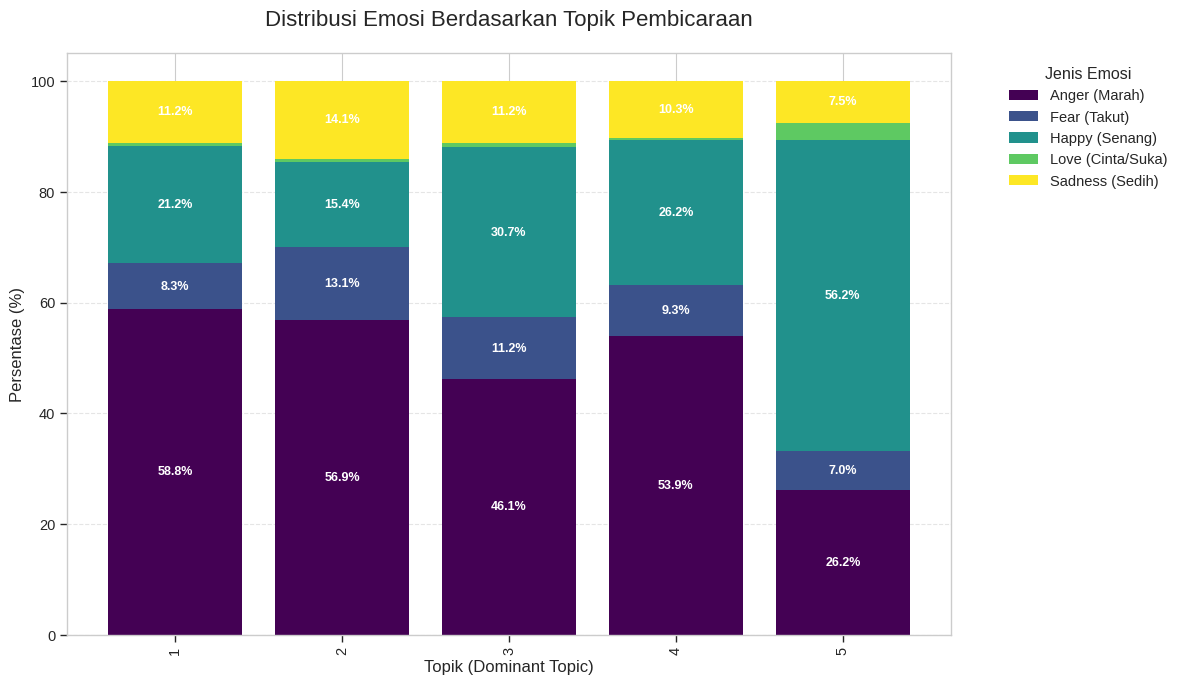

Grafik berhasil dibuat dan disimpan sebagai 'grafik_emosi_per_topik.png'.


In [6]:
# Membuat Plot Stacked Bar Chart
plt.figure(figsize=(12, 7))

# Plotting data persentase
ax = emotion_topic_pct.plot(
    kind='bar',
    stacked=True,
    colormap='viridis',
    figsize=(12, 7),
    width=0.8
)

# Kustomisasi Grafik
plt.title('Distribusi Emosi Berdasarkan Topik Pembicaraan', fontsize=16, pad=20)
plt.xlabel('Topik (Dominant Topic)', fontsize=12)
plt.ylabel('Persentase (%)', fontsize=12)
plt.legend(title='Jenis Emosi', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Menambahkan label angka pada bar
for c in ax.containers:
    # Hanya tampilkan label jika persentase > 5% agar tidak menumpuk
    labels = [f'{v.get_height():.1f}%' if v.get_height() > 5 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=9, color='white', weight='bold')

plt.tight_layout()

# Simpan gambar untuk laporan
plt.savefig('grafik_emosi_per_topik.png', dpi=300)
plt.show()

print("Grafik berhasil dibuat dan disimpan sebagai 'grafik_emosi_per_topik.png'.")

In [10]:
# Jumlah contoh yang ingin ditampilkan per kategori
jumlah_contoh = 3

# Mendapatkan list unik topik
topik_list = sorted(df['dominant_topic'].unique())

print("CONTOH KOMENTAR PER TOPIK DAN EMOSI")

for topik in topik_list:
    print(f"\nTOPIK {topik}")
    # Ambil data khusus topik ini
    df_topik = df[df['dominant_topic'] == topik]

    # Cek setiap jenis emosi yang ada di topik ini
    emosi_di_topik = df_topik['emotion_label'].unique()

    for emosi in sorted(emosi_di_topik):
        print(f"\n[ {emosi} ]")

        # Ambil sampel komentar
        sampel = df_topik[df_topik['emotion_label'] == emosi].head(jumlah_contoh)

        for i, row in enumerate(sampel.itertuples(), 1):
            print(f"{i}. \"{row.textDisplay}\"")

CONTOH KOMENTAR PER TOPIK DAN EMOSI

TOPIK 1

[ Anger (Marah) ]
1. "Terlalu banyak otak kosong dan terlalu banyak penjilat di negara ini, sebanyak apapun bersuara tidak akan ada pengaruhnya"
2. "Pembahasannya bisa di ganti gak bang bahas gimana indonesia itu hanya bahas isu yang gak penting sedangkan negara maju lain udah bahas bagaimana mencari energi terbarukan untuk dptkan pendapatan devisa"
3. "Saudara saudaraku sebangsa setanah air<br>Kita rakyat<br><br>Jangan di permainkan oleh oknum oknum di dalam istitusi besar bahkan pensiunan<br>Yg rakus dan sengaja <br>Mencari gara gara dengan kita rakyat.<br>HEBAT SAUDARAKU FERRY<br>ANDA LEBIH MERAH PUTIH<br>dibanding<br>Mereka yg saat ini menyerangmu dan merasa paling merah putih"

[ Fear (Takut) ]
1. "Benar Senjata kita coma otak, makanya jangan mudah percaya siapain, Suasana seperti ini bayak yang ambil kesempatan buat memecah belah"
2. "Saya menduga kamu tidak melakukan timeline reconstruction, cluster and pattern detection, dan cross v

In [8]:
import google.colab.files

# 1. Simpan Data Lengkap (Dataset + Label Emosi)
filename_full = 'hasil_analisis_lengkap.csv'
df.to_csv(filename_full, index=False, encoding='utf-8-sig')

print(f"File 1 berhasil dibuat: {filename_full}")
print("- Berisi seluruh data komentar beserta label emosi dan topiknya.")

# 2. Membuat untuk lampiran
# Ini membuat tabel rapi berisi: Topik | Emosi | Contoh Komentar
lampiran_data = []

for topik in topik_list:
    df_topik = df[df['dominant_topic'] == topik]
    for emosi in df_topik['emotion_label'].unique():
        # Ambil 5 contoh per emosi per topik
        contoh_teks = df_topik[df_topik['emotion_label'] == emosi]['textDisplay'].head(5).tolist()

        for teks in contoh_teks:
            lampiran_data.append({
                'Topik': f"Topik {topik}",
                'Jenis Emosi': emosi,
                'Contoh Komentar': teks
            })

df_lampiran = pd.DataFrame(lampiran_data)
filename_lampiran = 'lampiran_contoh.csv'
df_lampiran.to_csv(filename_lampiran, index=False, encoding='utf-8-sig')

print(f"File 2 berhasil dibuat: {filename_lampiran}")

File 1 berhasil dibuat: hasil_analisis_lengkap.csv
- Berisi seluruh data komentar beserta label emosi dan topiknya.
File 2 berhasil dibuat: lampiran_contoh.csv


In [11]:
df_hasil1 = pd.read_csv('hasil_analisis_lengkap.csv')
df_hasil1.head()

,publishedAt,authorDisplayName,textDisplay,likeCount,text_clean,dominant_topic,topic_probability,text_processed,emotion_label
0,2025-12-09T02:24:10Z,@Nekokun-k8k,Makasih berkat anda gua jadi bodoh amat kemarin,0,makasih berkat bodoh kemarin,1,0.445661,makasih berkat kamu saya jadi bodoh amat kemarin,Happy (Senang)
1,2025-12-03T16:05:46Z,@joviputr1238,Anak abah CS DAN BANTENG pasti pada emosi 😅 k...,0,anak abah banteng emosi rencana gagal,3,0.415313,anak abah cs dan banteng pasti pada emosi 😅 ka...,Anger (Marah)
2,2025-11-22T18:29:33Z,@rudiumardani5494,Tau enggak china pki....tai china bangsat....b...,0,tau china pki tai china bangsat brengsek tumba...,3,0.425407,tau tidak china pki....tai china bangsat....br...,Anger (Marah)
3,2025-11-22T18:28:20Z,@rudiumardani5494,Harusnya elu susul tuh si atheis LEE KUAN YEW...,0,elu susul tuh atheis lee kuan yew bin poor lion,5,0.333119,harusnya elu susul tuh si atheis lee kuan yew....,Anger (Marah)
4,2025-11-20T03:55:24Z,@Bossge1091,Terlalu banyak otak kosong dan terlalu banyak ...,1,otak kosong penjilat negara apapun bersuara pe...,1,0.384696,terlalu banyak otak kosong dan terlalu banyak ...,Anger (Marah)


In [12]:
df_hasil2 = pd.read_csv('lampiran_contoh.csv')
df_hasil2.head()

,Topik,Jenis Emosi,Contoh Komentar
0,Topik 1,Happy (Senang),Makasih berkat anda gua jadi bodoh amat kemarin
1,Topik 1,Happy (Senang),Pasti &quot;geter&quot; Mereka melihat video i...
2,Topik 1,Happy (Senang),Ambo doakan uda ferri selalu dan selallu dalam...
3,Topik 1,Happy (Senang),"Tetap sabar dan tenang bg, cerdaskan publik te..."
4,Topik 1,Happy (Senang),Keren bang<br>Mari kita jaga tanah air kita
